In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
source = pd.read_csv('master.csv')

# Preprocessing:

## null analysis

In [3]:
data = source.copy()
nulls = data.isnull().sum()

for k,v in nulls.items():
    if v!=0:
        print(k,v/len(data))

HDI for year 0.699352983465133


So : 70% of the dataset for the human development index is null. This is too much to impute - let's drop.

In [4]:
del data['HDI for year']

## Over complete basis (features present which can be written as other features).

In [5]:
data.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,"2,156,624,900",796,Boomers


The columns suicides/100k pop and country-year are producing an overcomplete basis of features since:

* suicides/100k pop can be written as suicides_no and populations
* country-year can be writtten in terms of the columns country and year
* It is tempting to think that genenration and age have a strong association, however this is not the case since 
this makes refenrence to a fixed timescale in the past. I.e. a 25 year old baby boomer groes to become a 70 year old baby boomer.

Thus, we can delete those two columns:

In [6]:
del data['suicides/100k pop']
del data['country-year']

## type analysis (making data ordinal, one -hot etc. where required)

For most of our analysis and modelling it will be useful to make the data type ordinal, categorical or numerical where nessecary. So we do that, going column by column.

In [7]:
columns = data.columns

In [8]:
type_df = pd.DataFrame(index = columns)
val = []
for c in columns:
    val.append(data[c].map(lambda x: type(x)).values.all())
type_df['types'] = val
type_df

,types
country,<class 'str'>
year,<class 'int'>
sex,<class 'str'>
age,<class 'str'>
suicides_no,<class 'int'>
population,<class 'int'>
gdp_for_year ($),<class 'str'>
gdp_per_capita ($),<class 'int'>
generation,<class 'str'>


First issue: the type for gdp_for_year ($) should not be a string...

In [9]:
data[' gdp_for_year ($) '].head()

0    2,156,624,900
1    2,156,624,900
2    2,156,624,900
3    2,156,624,900
4    2,156,624,900
Name:  gdp_for_year ($) , dtype: object

In [10]:
#ok so it has columns in it - 
def long_number_to_int(longnumber):
    try:
        return int(longnumber)
    except ValueError:
        return int(''.join(longnumber.split(',')))
    
data['gdp_for_year($)'] = data[' gdp_for_year ($) '].map(lambda x: long_number_to_int(x))
del data[' gdp_for_year ($) ']

Age and generation should both be ordinal numerical values.

In [11]:
age_groups = data['age'].unique()
age_groups

array(['15-24 years', '35-54 years', '75+ years', '25-34 years',
       '55-74 years', '5-14 years'], dtype=object)

In [12]:
mapper = {'5-14 years':0, '15-24 years':1,'25-34 years':2,'35-54 years':3,'55-74 years':4,'75+ years':5}
data['age'] = data['age'].map(lambda x: mapper[x])

In [13]:
generation_groups = data['generation'].unique()
generation_groups

array(['Generation X', 'Silent', 'G.I. Generation', 'Boomers',
       'Millenials', 'Generation Z'], dtype=object)

In [14]:
#going youngest to eldest
mapper  = {'Generation Z':0,'Millenials':1,'Generation X':2,'Boomers':3,'Silent':4,'G.I. Generation':5}
data['generation'] = data['generation'].map(lambda x: mapper[x])

In [15]:
data.to_csv('output1.csv')

Now let's make country, and set ordinal.

In [16]:
#one hot encoding should be applied to:
    # country
    # sex
    # generation
    
from sklearn.preprocessing import OneHotEncoder

def transform_to_one_hot(dataframe, column_name):
    enc = OneHotEncoder()
    enc.fit(dataframe[column_name].values.reshape(-1,1))
    transformed = enc.transform(dataframe[column_name].values.reshape(-1,1)).toarray()
    #the result to 2 columns - we only need one:
    if len(enc.categories_[0]) == 2:
        data[enc.categories_[0][0]] = transformed[:,0]
    else:
        for i in range(0,len(transformed[0])):
            dataframe[enc.categories_[0][i]] = transformed[:,i]
            
    return dataframe

for col in ['sex', 'country']:
    transform_to_one_hot(data, col)

In [17]:
data.to_csv('output2.csv')

## Basic EDA questions...

In [18]:
data = pd.read_csv('output1.csv',index_col = 0)
age_mapper = {'5-14 years':0, '15-24 years':1,'25-34 years':2,'35-54 years':3,'55-74 years':4,'75+ years':5}
gen_mapper  = {'Generation Z':0,'Millenials':1,'Generation X':2,'Boomers':3,'Silent':4,'G.I. Generation':5}
inv_age_mapper = {v:k for k,v in age_mapper.items()}
inv_gen_mapper = {v:k for k,v in gen_mapper.items()}

In [19]:
# question 1: how has the total number of suicides changes over time amoung different age groups and genders
# per country

In [20]:
all_years = np.sort(data['year'].unique())

In [21]:
def to_timeseries(country, sex):
    tmp = data[(data['country'] == country) & (data['sex'] == sex)].groupby(['age','year']).first()
    res = dict(tmp['suicides_no'])
    
    result = {}
    for k,v in res.items():
        if k[0] not in result.keys():
            result[k[0]] = [[k[1]],[v]]
        else:
            temp = result[k[0]]
            temp[0].append(k[1])
            temp[1].append(v)
            result[k[0]] = temp
            
    return result

In [22]:
countries = data['country'].unique()
countries

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

In [23]:
# question 1a : more precisely - we can ask specific questions like how has the suicide rate changed over time for female 
# Austrians for diffrent age rates

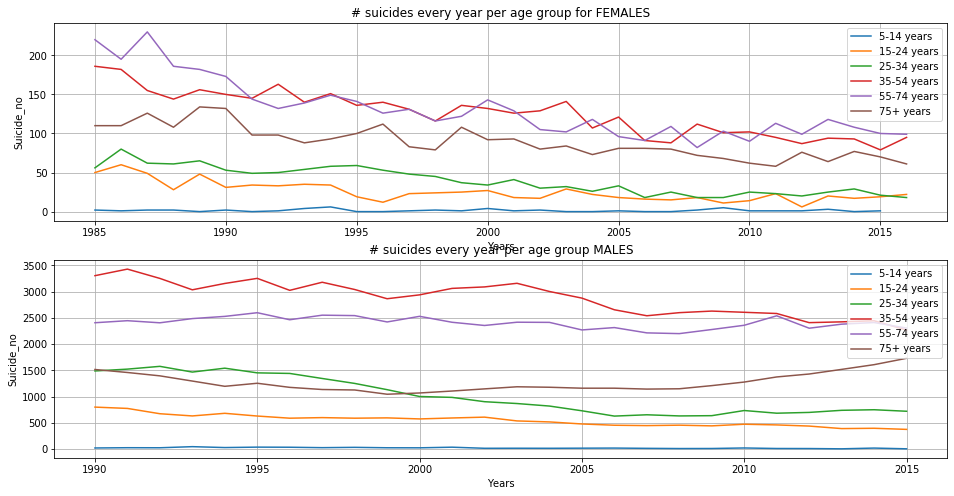

In [24]:
fig, axs = plt.subplots(2, figsize = (16,8))
result = to_timeseries('Austria','female')
for age_group in result.keys():
    x,y = result[age_group]
    axs[0].plot(x,y, label = inv_age_mapper[age_group])
    axs[0].legend()
    
axs[0].set_xlabel('Years')
axs[0].set_ylabel('Suicide_no')
axs[0].set_title('# suicides every year per age group for FEMALES')
axs[0].grid()


result = to_timeseries('Germany','male')
for age_group in result.keys():
    x,y = result[age_group]
    axs[1].plot(x,y, label = inv_age_mapper[age_group])
    axs[1].legend()
    
axs[1].set_xlabel('Years')
axs[1].set_ylabel('Suicide_no')
axs[1].set_title('# suicides every year per age group MALES')
axs[1].grid()
plt.show()

In [25]:
#Can we see a trend? We can appeal to a very simply linear regression to ask this.
from sklearn import linear_model


MSEs = []
t_coef = []
t2_coef = []
t3_coef = []
intercept = []
country_list = []
sex_list = []
age_group_list = []


for country in tqdm_notebook(countries):
    for sex in ['male','female']:
        for age_group in [0,1,2,3,4,5]:
            

            result = to_timeseries(country,sex)

            model = linear_model.LinearRegression()
            
            try:
                X = np.array(result[age_group][0]).reshape(-1,1)
            except:
                continue
            
            t0 = X[0]
            t = [0]
            for i in range(0,len(X)-1):
                t.append((X[i+1] - t0).item())
            X = np.array(t)
            X = np.concatenate([[X],[X**2],[X**3]],0).T #adding a quadratic term
            y = np.array(result[age_group][1]).reshape(-1,1)
            model.fit(X,y)
            
            
            coef = model.coef_[0]
            t_coef.append(coef[0])
            t2_coef.append(coef[1])
            t3_coef.append(coef[2])
            
            intercept.append(model.intercept_[0])
            diff = model.predict(X) - y
            MSE = np.mean(diff**2)
            
            MSEs.append(MSE)
              
            country_list.append(country)
            sex_list.append(sex)
            age_group_list.append(age_group)


In [26]:
trend_df = pd.DataFrame({'Country':country_list,'Sex':sex_list,'Age group':age_group_list,'Linear term':t_coef,\
                        'Quadratic term':t2_coef,'Cubic term':t3_coef,'Intercept':intercept,'MSE':MSEs})

In [27]:
trend_df['MSE'].describe()

count    1.210000e+03
mean     3.377685e+03
std      5.094705e+04
min      0.000000e+00
25%      8.695881e-01
50%      1.610352e+01
75%      1.362289e+02
max      1.629017e+06
Name: MSE, dtype: float64

In [28]:
# Let's drop very bad MSE outliers for which the model made no sense - we keep upto th 75% percentile
trend_df_75 = trend_df[trend_df['MSE'] < 140]

In [29]:
# the 75% percentile is of the order 2 - and there is a huge discrepency between the maximum and the upper range 
# thus I reckon we can view the maximum as an outlier in this case.

# Let's try to cluster in the regression coefficient space:

coefficients = trend_df_75[['Linear term','Quadratic term']]


In [30]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(coefficients.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
clusters = kmeans_model.cluster_centers_.T

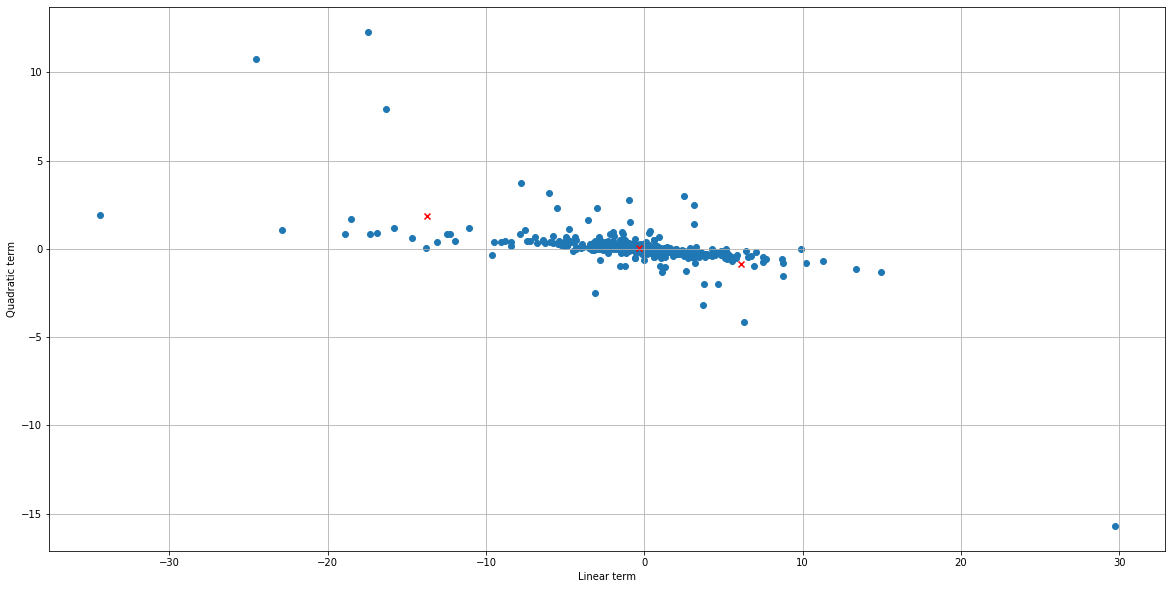

In [32]:
plt.figure(figsize=(20,10))
plt.scatter(coefficients['Linear term'].values, coefficients['Quadratic term'].values)
plt.scatter(clusters[0],clusters[1], color = 'red', marker = 'x')
plt.xlabel('Linear term')
plt.ylabel('Quadratic term')

plt.grid()

In [33]:
# So we see three distinct area - giving us two bits on information - where trends increased, decreased 
# and stayed rouhgly the same. We also see some outlier points with a large (positive and negative) quadratic 
# terms, however we did not need the cluster to see this. This gives us an idea of the spread of the data.

# we can drill down further into the linear term...


In [34]:
trend_df_75['Kmeans_cluster'] = trend_df_75[['Linear term','Quadratic term']].apply(lambda x : kmeans_model.predict([[x[0],x[1]]])[0],1)

In [35]:
from seaborn import heatmap

[-13.71634932   1.84825283]


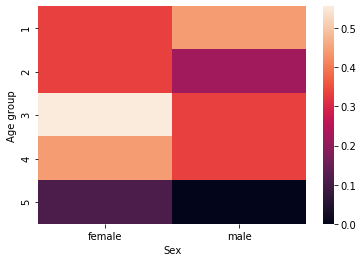

In [36]:
# cluster 1 : the decreasing trend
print(kmeans_model.cluster_centers_[1])
dec_trend = trend_df_75[trend_df_75['Kmeans_cluster'] == 1]
res = dec_trend.groupby(['Age group', 'Sex']).size()
res = res.unstack(level=-1).fillna(0)/len(res)
heatmap(res)

[-0.3056131   0.04213307]


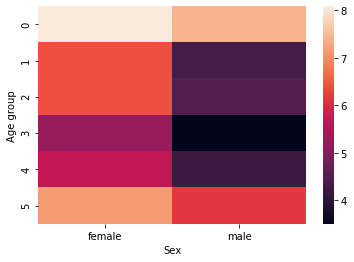

In [37]:
# cluster 0 : almost no change
print(kmeans_model.cluster_centers_[0])
dec_trend = trend_df_75[trend_df_75['Kmeans_cluster'] == 0]
res = dec_trend.groupby(['Age group', 'Sex']).size()
res = res.unstack(level=-1).fillna(0)/len(res)
heatmap(res)

[ 6.11534834 -0.88076797]


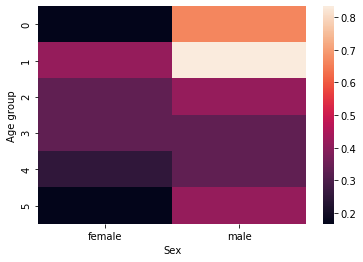

In [38]:
# cluster 2 : increasing trend
print(kmeans_model.cluster_centers_[2])
dec_trend = trend_df_75[trend_df_75['Kmeans_cluster'] == 2]
res = dec_trend.groupby(['Age group', 'Sex']).size()
res = res.unstack(level=-1).fillna(0)/len(res)
heatmap(res)

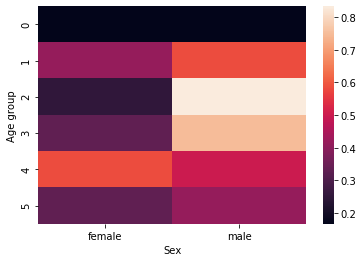

In [39]:
# What about the quadratically increasing and decreasing group?

# +ve increasing
idx = coefficients['Quadratic term'][coefficients['Quadratic term'] > 0.4].index
res = trend_df_75.loc[idx].groupby(['Age group', 'Sex']).size()
res = res.unstack(level=-1).fillna(0)/len(res)
heatmap(res)

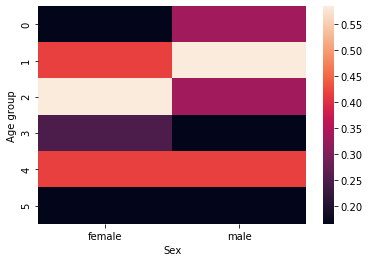

In [40]:
# -ve increasing
idx = coefficients['Quadratic term'][coefficients['Quadratic term'] < -0.4].index
res = trend_df_75.loc[idx].groupby(['Age group', 'Sex']).size()
res = res.unstack(level=-1).fillna(0)/len(res)
heatmap(res)

In [41]:
from sklearn.feature_selection import chi2

temp = data[['sex','age']]
value = (temp['sex'] + '_' +temp['age'].astype(str)).values
temp.loc[:, ('sex_age')] = value

temp.loc[:,('sex')] = np.array(temp['sex'] == 'male',int)

code_mapper = {temp['sex_age'].unique()[i]:i for i in range(len(temp['sex_age'].unique()))}
temp.loc[:,('sex_age')] = temp['sex_age'].map(lambda x: code_mapper[x])

X = temp.values

y = data['suicides_no'].values

In [42]:
chi2_vals, p_values = chi2(X,y)

In [43]:
temp.columns

Index(['sex', 'age', 'sex_age'], dtype='object')

In [44]:
p_values

array([1.00000000e+00, 1.02116412e-22, 0.00000000e+00])

In [45]:
# From this we conclude that it cannot be rules out that the suicide amount and age are not associated to 
#each other.

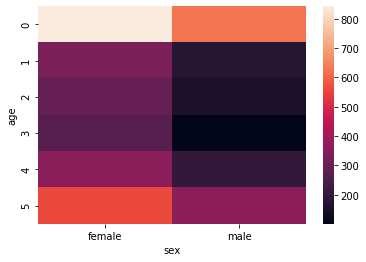

In [46]:
# are there any groups/countries that have absolutely no suicides reported?
no_suicides = data[data['suicides_no'] == 0]


# is there some grouping at all?

res = no_suicides.groupby(['age', 'sex']).size()
res = res.unstack(level=-1).fillna(0)
heatmap(res)

In [47]:
# All countries aside from this list had no suicides for some age group
always_had_suicides = list(set(data['country'].unique()) - set(no_suicides['country'].unique()))
always_had_suicides

['Mongolia',
 'United States',
 'Mexico',
 'Brazil',
 'Poland',
 'Argentina',
 'Sri Lanka',
 'Ukraine',
 'Ecuador',
 'Russian Federation',
 'Germany',
 'France',
 'Canada',
 'Turkey',
 'Uzbekistan',
 'Japan',
 'Kazakhstan',
 'Republic of Korea',
 'Belarus']

In [48]:
# in which countries do the suicide rates between males and females correlate most strongly and which the weakest 
# - in which age group is this the case?

def correlation_between_sex(age, result_male, result_female, common_years_threshold = 15):
    age_groups = list(result_male.keys())

    years1, values1 = result_male[age]
    years2, values2 = result_female[age]

    common_years = []
    years1_idx = []
    years2_idx = []
    for i,year1 in enumerate(years1):
        for j,year2 in enumerate(years2):
            if year1 in all_years and year2 in all_years and year1 == year2:
                common_years.append(year1)
                years1_idx.append(i)
                years2_idx.append(j)
                
    if len(common_years) < common_years_threshold:
        raise ValueError('not enough number of common year data')

    val1 = np.array(values1)[years1_idx]
    val2 = np.array(values2)[years2_idx]
    return np.corrcoef(val1,val2)[0][1]

result = {}
for country in tqdm_notebook(countries):
    result[country] = {}
    resultm = to_timeseries(country, 'male')
    resultf = to_timeseries(country, 'female')
    
    for age in resultm.keys(): 
        try:
            corr_res = correlation_between_sex(age,resultm,resultf)
        except ValueError:
            if country in result.keys():
                result.pop(country)
            break
        if np.isnan(corr_res): #this happens if a country has reported zero suicides
            continue
        result[country][age] = corr_res

In [49]:
maximum = -np.inf
minimum = +np.inf
max_string = None #finds positive correlations
min_string = None #finds negative correlations

minimum_absolute = +np.inf
abs_string = None #finds genuine low correlations


for k,v in result.items():
    age = max(v, key=v.get)
    country = k
    value = result[k][age]
    
    if value > maximum:
        max_string = country + '_' + inv_age_mapper[age]
        maximum = value
    
    if value < minimum:
        min_string = country + '_' + inv_age_mapper[age]
        minimum = value
        
    if abs(value) < minimum_absolute:
        abs_string = country + '_' + inv_age_mapper[age]
        minimum_absolute = abs(value)

In [50]:
c_, a_ = max_string.split('_')
age = age_mapper[a_]

print('The maximum positive correlation amoung males and female suicide rates occurs for age group {0} \
for country {1} with correlation {2:.5f}'.format(a_, c_,result[c_][age]))


The maximum positive correlation amoung males and female suicide rates occurs for age group 55-74 years for country Republic of Korea with correlation 0.99287


In [51]:
c_, a_ = min_string.split('_')
age = age_mapper[a_]

print('The maximum negative correlation amoung males and female suicide rates occurs for age group {0} \
for country {1} with correlation {2:.5f}'.format(a_, c_,result[c_][age]))

The maximum negative correlation amoung males and female suicide rates occurs for age group 55-74 years for country Antigua and Barbuda with correlation -0.06934


In [52]:
c_, a_ = abs_string.split('_')
age = age_mapper[a_]

print('The absolute lowest correlation amoung males and female suicide rates occurs for age group {0} \
for country {1} with correlation {2:.5f}'.format(a_, c_,result[c_][age]))

The absolute lowest correlation amoung males and female suicide rates occurs for age group 55-74 years for country Antigua and Barbuda with correlation -0.06934


In [53]:
# highest and lowest correlation between ages per country

In [55]:
ages = [0,1,2,3,4,5]
country_names = []
key_pair_max = []
key_values_max = []
key_pair_min = []
key_values_min= []
for c in tqdm_notebook(countries):
    tmp = data[(data['country'] == c)]
    tmp = tmp.groupby(['year']).first()
    temp_df = pd.DataFrame(index = tmp.index)
    for age in ages:
        tmp = data[(data['country'] == c) & (data['age'] == age)]
        tmp = tmp.groupby(['year']).first()
        temp_df[age] = tmp['suicides_no']
    
    try:
        res = dict(temp_df.corr().unstack().sort_values(ascending = False).drop_duplicates())

        for k in res.copy():
            if k[0] == k[1]:
                res.pop(k)
    
        key_max = max(res, key=res.get)
        key_min = min(res, key=res.get)
        value_max = res[key_max]
        value_min = res[key_min]

        country_names.append(c)
        key_pair_max.append(key_max)
        key_values_max.append(value_max)
        key_pair_min.append(key_min)
        key_values_min.append(value_min)
    except:
        continue
        

In [56]:
age_corr_df = pd.DataFrame({'country':country_names,'age_pairs_max':key_pair_max,'age_corr_values_max':key_values_max,\
             'age_pairs_min':key_pair_min,'age_corr_values_min':key_values_min}).set_index('country')

In [57]:
country_row = pd.DataFrame(age_corr_df['age_corr_values_max']).idxmax()['age_corr_values_max']
age_corr_df.loc[country_row]

age_pairs_max            (4, 3)
age_corr_values_max    0.989472
age_pairs_min            (5, 0)
age_corr_values_min    0.877221
Name: Mexico, dtype: object

In [58]:
country_row = pd.DataFrame(age_corr_df['age_corr_values_min']).idxmin()['age_corr_values_min']
age_corr_df.loc[country_row]

age_pairs_max            (5, 2)
age_corr_values_max    0.917663
age_pairs_min            (5, 4)
age_corr_values_min          -1
Name: Oman, dtype: object

In [59]:
# which country has the youngest highest suicide rate?

temp_df = data[(data['age'] == 0) & (data['suicides_no'] > 0)]
idx = temp_df['suicides_no'].idxmax()
temp_df.loc[idx]

country               Russian Federation
year                                2000
sex                                 male
age                                    0
suicides_no                          404
population                       9986252
gdp_per_capita ($)                  1879
generation                             1
gdp_for_year($)             259708496267
Name: 21078, dtype: object

In [60]:
# Econonic issues - can we cluster?

# data question - are the gdp values constant amoung age groups and sexes for each country?

if len(data['gdp_per_capita ($)'].unique()) == len(data['country'].unique()):
    print('gpd_per_capita same number of unique values as country')
else:
    print('gdp_per_capita ($) vs. country : no obvious relation')

if len(data['gdp_for_year($)'].unique()) == len(data['country'].unique()):
    print('gdp_for_year same number of unique values as country')
else:
    print('gdp_for_year ($) vs. country : no obvious relation')

gdp_per_capita ($) vs. country : no obvious relation
gdp_for_year ($) vs. country : no obvious relation


In [61]:
# so, let us look at gender, age group time series of both sucide rates and gdps 
# and see what the correlation matrices look like

In [62]:
c,s,a = 'Albania','male',4

country_label = []
sex_label = []
age_group_label = []
suicide_capita_corr = []
suicide_gdp_year_corr = []
n_data_points = []

for c in tqdm_notebook(countries):
    for a in [0,1,2,3,4,5]:
        for s in ['male','female']:
            try:

                tmp = data[(data['country'] == c) & (data['sex'] == s) & (data['age'] == a)].groupby(['year']).first()
                n_data_points.append(len(tmp))
                
                corr_df = tmp[['suicides_no','gdp_per_capita ($)','gdp_for_year($)']].corr()
                result = dict(corr_df['suicides_no'])
                
                
         

                country_label.append(c)
                sex_label.append(s)
                age_group_label.append(a)

                suicide_capita_corr.append(result['gdp_per_capita ($)'])
                suicide_gdp_year_corr.append(result['gdp_for_year($)'])
                
            except:
                continue

temp_df = pd.DataFrame({'Country':country_label, 'Sex':sex_label,'Age':age_group_label,\
                        'suicide_gdp_capita_corr':suicide_capita_corr,\
                        'suicide_gdp_year_corr':suicide_gdp_year_corr, 'n_data_points':n_data_points})

In [63]:
temp_df.head()

,Country,Sex,Age,suicide_gdp_capita_corr,suicide_gdp_year_corr,n_data_points
0,Albania,male,0,0.137995,0.142640,22
1,Albania,female,0,-0.082816,-0.073315,22
2,Albania,male,1,-0.456012,-0.445258,22
3,Albania,female,1,-0.215636,-0.200096,22
4,Albania,male,2,-0.287190,-0.277046,22


In [64]:
idx = temp_df['suicide_gdp_capita_corr'].idxmax()
temp_df.loc[idx]

Country                    Bosnia and Herzegovina
Sex                                          male
Age                                             0
suicide_gdp_capita_corr                         1
suicide_gdp_year_corr                          -1
n_data_points                                   2
Name: 168, dtype: object

In [65]:
#this comes from the lack data..let's put a lower bound on the number of data points
idx = temp_df[temp_df['n_data_points']>20]['suicide_gdp_capita_corr'].idxmax()
temp_df.loc[idx]

Country                    United States
Sex                               female
Age                                    3
suicide_gdp_capita_corr         0.982835
suicide_gdp_year_corr           0.988487
n_data_points                         31
Name: 1183, dtype: object

In [66]:
# is this a tie? how many different demogrpahics high a positive correlation of suicide with the gdp

temp2 = temp_df[temp_df['n_data_points']>20]
temp2[temp2['suicide_gdp_capita_corr']  > 0.95]

,Country,Sex,Age,suicide_gdp_capita_corr,suicide_gdp_year_corr,n_data_points
838,Poland,male,5,0.960888,0.960733,24
1182,United States,male,3,0.980532,0.973014,31
1183,United States,female,3,0.982835,0.988487,31


In [67]:
# what about negative correlation

#this comes from the lack data..let's put a lower bound on the number of data points
idx = temp_df[temp_df['n_data_points']>20]['suicide_gdp_capita_corr'].idxmin()
temp_df.loc[idx]

Country                    Lithuania
Sex                             male
Age                                4
suicide_gdp_capita_corr    -0.944062
suicide_gdp_year_corr      -0.950279
n_data_points                     22
Name: 632, dtype: object

In [68]:
# is this a tie? how many different demogrpahics high a positive correlation of suicide with the gdp

temp2 = temp_df[temp_df['n_data_points']>20]
temp2[temp2['suicide_gdp_capita_corr']  < -0.91]

,Country,Sex,Age,suicide_gdp_capita_corr,suicide_gdp_year_corr,n_data_points
401,France,female,2,-0.915750,-0.925342,30
482,Hungary,male,1,-0.910478,-0.908059,26
621,Latvia,female,4,-0.913773,-0.907071,21
630,Lithuania,male,3,-0.939565,-0.935572,22
632,Lithuania,male,4,-0.944062,-0.950279,22
900,Russian Federation,male,0,-0.921782,-0.922616,27
1014,Slovenia,male,3,-0.922202,-0.925547,21


In [69]:
# How do age_group and generation and the time descrepency affect things?

data.groupby('generation').sum()

,year,age,suicides_no,population,gdp_per_capita ($),gdp_for_year($)
generation,,,,,,
0,2955886,0,15906,2503541842,37678558,949835197307338
1,11715748,4140,623459,10649461202,111331886,2880793919812842
2,12813552,10424,1532804,13472109292,99996594,2675391350202232
3,9980242,14622,2284498,13350511729,79750168,2143504656179764
4,12743414,27354,1781744,9220331647,111948324,2894448317634156
5,5466166,13090,510009,2126202724,28519510,852089117159382


In [70]:
data.groupby('generation').count()['country']

generation
0    1470
1    5844
2    6408
3    4990
4    6364
5    2744
Name: country, dtype: int64

In [71]:
# we can do a lot of the same analysis that we did for ages, but for generations..

In [72]:
def to_timeseries(country, sex):
    tmp = data[(data['country'] == country) & (data['sex'] == sex)].groupby(['generation','year']).first()
    res = dict(tmp['suicides_no'])
    
    result = {}
    for k,v in res.items():
        if k[0] not in result.keys():
            result[k[0]] = [[k[1]],[v]]
        else:
            temp = result[k[0]]
            temp[0].append(k[1])
            temp[1].append(v)
            result[k[0]] = temp
            
    return result




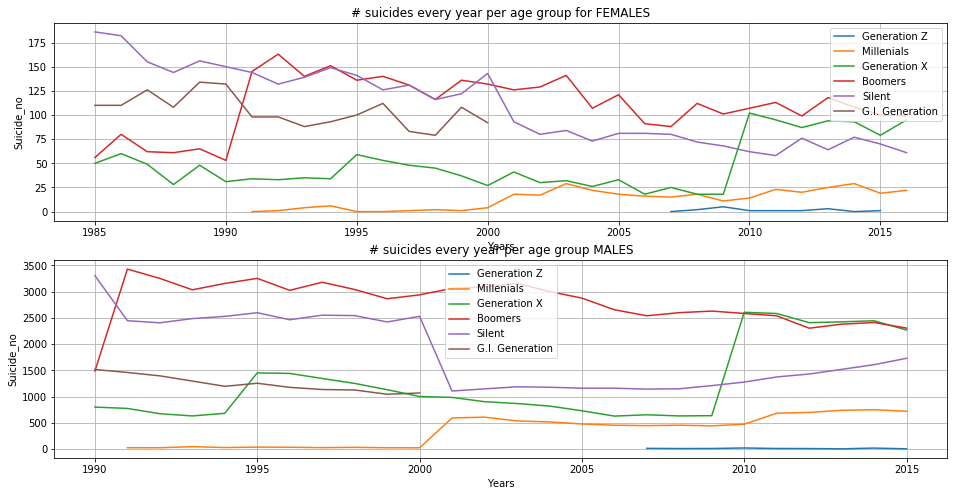

In [73]:
fig, axs = plt.subplots(2, figsize = (16,8))
result = to_timeseries('Austria','female')
for age_group in result.keys():
    x,y = result[age_group]
    axs[0].plot(x,y, label = inv_gen_mapper[age_group])
    axs[0].legend()
    
axs[0].set_xlabel('Years')
axs[0].set_ylabel('Suicide_no')
axs[0].set_title('# suicides every year per age group for FEMALES')
axs[0].grid()


result = to_timeseries('Germany','male')
for age_group in result.keys():
    x,y = result[age_group]
    axs[1].plot(x,y, label = inv_gen_mapper[age_group])
    axs[1].legend()
    
axs[1].set_xlabel('Years')
axs[1].set_ylabel('Suicide_no')
axs[1].set_title('# suicides every year per age group MALES')
axs[1].grid()
plt.show()

In [74]:
#Can we see a trend? We can appeal to a very simply linear regression to ask this.
from sklearn import linear_model


MSEs = []
t_coef = []
t2_coef = []
t3_coef = []
intercept = []
country_list = []
sex_list = []
gen_list = []


for country in tqdm_notebook(countries):
    for sex in ['male','female']:
        for gen in [0,1,2,3,4,5]:
            

            result = to_timeseries(country,sex)

            model = linear_model.LinearRegression()
            
            try:
                X = np.array(result[age_group][0]).reshape(-1,1)
            except:
                continue
            
            t0 = X[0]
            t = [0]
            for i in range(0,len(X)-1):
                t.append((X[i+1] - t0).item())
            X = np.array(t)
            X = np.concatenate([[X],[X**2],[X**3]],0).T #adding a quadratic term
            y = np.array(result[age_group][1]).reshape(-1,1)
            model.fit(X,y)
            
            
            coef = model.coef_[0]
            t_coef.append(coef[0])
            t2_coef.append(coef[1])
            t3_coef.append(coef[2])
            
            intercept.append(model.intercept_[0])
            diff = model.predict(X) - y
            MSE = np.mean(diff**2)
            
            MSEs.append(MSE)
              
            country_list.append(country)
            sex_list.append(sex)
            gen_list.append(gen)


In [75]:
trend_df = pd.DataFrame({'Country':country_list,'Sex':sex_list,'GEn group':gen_list,'Linear term':t_coef,\
                        'Quadratic term':t2_coef,'Cubic term':t3_coef,'Intercept':intercept,'MSE':MSEs})

In [76]:
trend_df['MSE'].describe()

count     1116.000000
mean       561.110019
std       2983.468127
min          0.000000
25%          0.285714
50%          9.934784
75%        132.719897
max      36361.128109
Name: MSE, dtype: float64

In [77]:
# Let's drop very bad MSE outliers for which the model made no sense - we keep upto th 75% percentile
trend_df_75 = trend_df[trend_df['MSE'] < 140]

In [78]:
# the 75% percentile is of the order 2 - and there is a huge discrepency between the maximum and the upper range 
# thus I reckon we can view the maximum as an outlier in this case.

# Let's try to cluster in the regression coefficient space:

coefficients = trend_df_75[['Linear term','Quadratic term']]

In [79]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(coefficients.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [80]:
clusters = kmeans_model.cluster_centers_.T

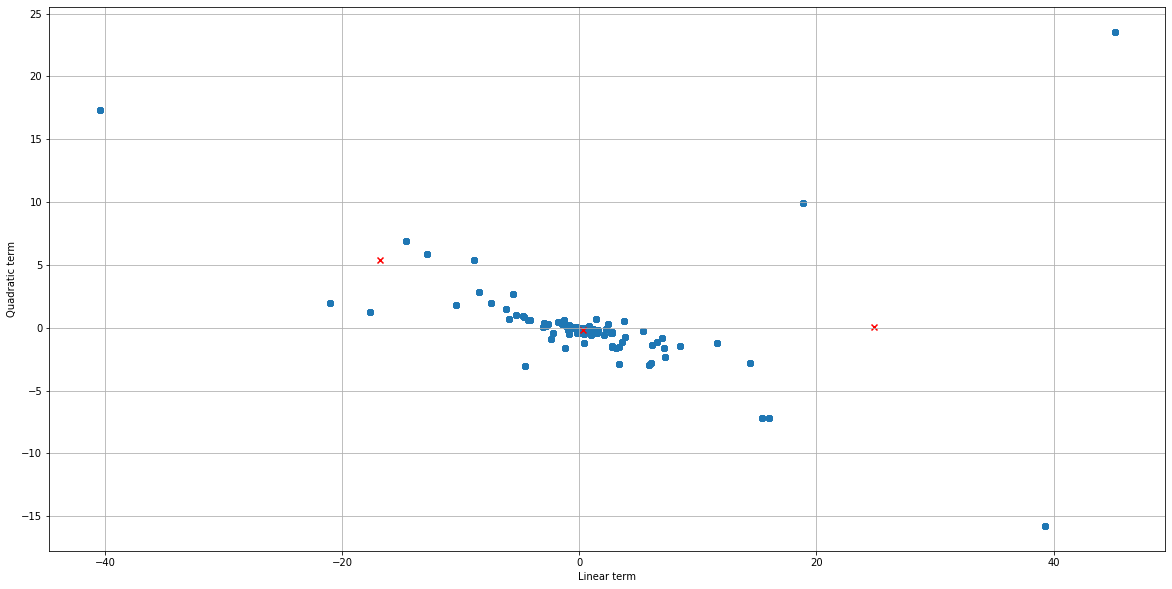

In [81]:
plt.figure(figsize=(20,10))
plt.scatter(coefficients['Linear term'].values, coefficients['Quadratic term'].values)
plt.scatter(clusters[0],clusters[1], color = 'red', marker = 'x')
plt.xlabel('Linear term')
plt.ylabel('Quadratic term')

plt.grid()

In [82]:
trend_df_75['Kmeans_cluster'] = trend_df_75[['Linear term','Quadratic term']].apply(lambda x : kmeans_model.predict([[x[0],x[1]]])[0],1)

In [83]:
trend_df_75['Kmeans_cluster'] 

0       0
1       0
2       0
3       0
4       0
       ..
1111    0
1112    0
1113    0
1114    0
1115    0
Name: Kmeans_cluster, Length: 858, dtype: int64